<div style="background:#FFFFAA">
<img src="./logo.jpg", width=150, ALIGN="left", border=20>
<h1>L2RPN Starting Kit </h1> 

<br>This code was tested with <br>
Python 3.6.6 |Anaconda custom (64-bit)| (default, Nov 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. The dataset used in this challenge is from <a href="https://github.com/MarvinLer/pypownet">pypownet</a>, made by Marvin Lerousseau, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
Founder of pypownet was Marvin Lerousseau. The competition protocol was designed by Isabelle Guyon. Our mentors are Balthazar Donon and Antoine Marot. Pypownet, 2017. https://github.com/MarvinLer/pypownet. The baseline methods were inspired by work performed by Kimang Khun.
 <br> 
</div>

In [1]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide data with the starting kit.
    <br>
</div>

## Electrical grid
<div >
<img src="./ExampleGrid.JPG", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines connected the nodes of the network.

For the following example, we take the case where there are 11 loads and 5 prods and particularly the hard level. Furthermore, the information shown are only those of January.

In [2]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*

chronics  configuration.yaml  reference_grid.m


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" to explore the data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')

## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. This information appears in the \_N\_loads\_p.csv. Note that the power needed is cyclic during the day. In our particular case, the load 3_C151.15 is the one which needs power the most power. The loads for the other levels are pretty similar with a load needing much more power than the others.

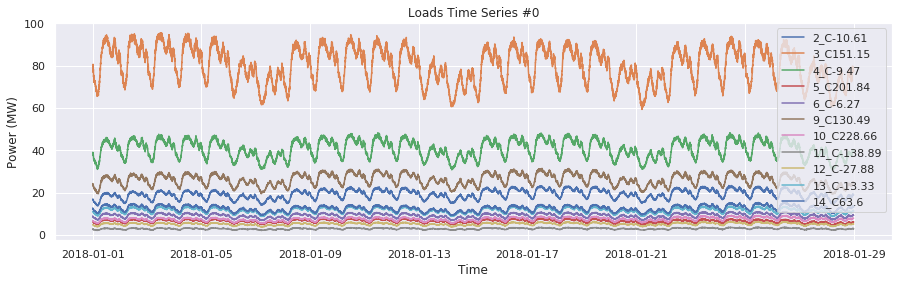

In [4]:
plt.figure(figsize=[15,4])
plt.title('Loads Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_loads_p[str(0)])
plt.legend(list(df_loads_p[str(0)]))
plt.show()

## Production

The active power of the productions is shown below. In the easy mode, each one of them is stable contrary to the medium and hard modes where the productions are much more heterogeneous.

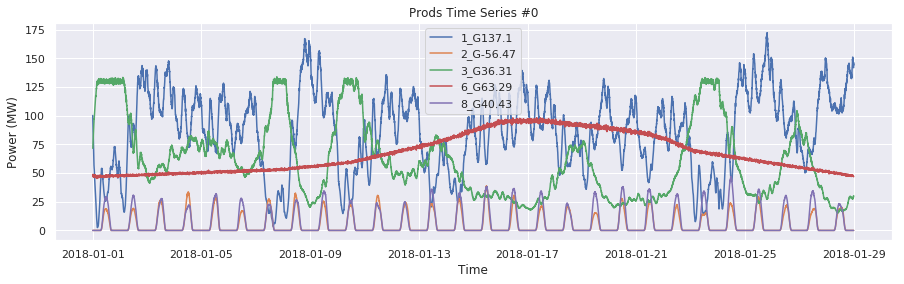

In [5]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

## Maintenance

Maintenance exist only for the hard mode. When a maintenance happens for a production, the voltage magnitudes of the associated production is set to 0 in \_N\_prods\_v.csv for a number of timesteps. Here, two maintenances happen in January.

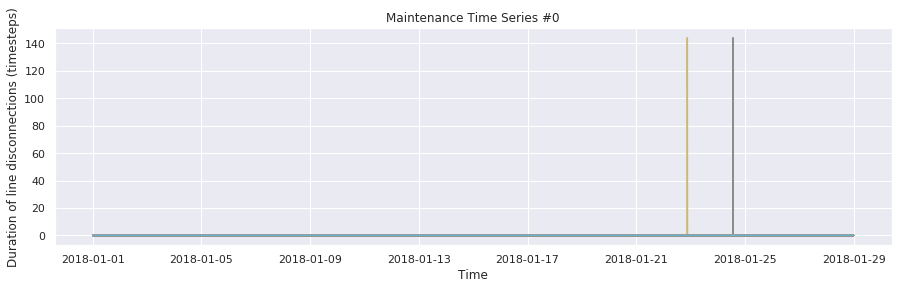

In [6]:
plt.figure(figsize=[15,4])
plt.title('Maintenance Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_maintenance[str(0)])
plt.show()

## Hazard

Again, hazards only happen with the hard mode. They represent external events that break lines from time to time, be it natural hazards or ones related to the network itself.

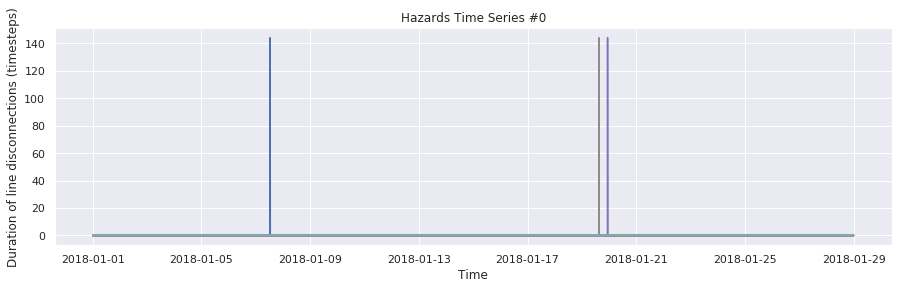

In [7]:
plt.figure(figsize=[15,4])
plt.title('Hazards Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_hazards[str(0)])
plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with pypownet</h2>
    <p>
We reload the data with the environment class of pypownet
   <br>
    
To win, flows in a line have to stay under a threshold. Above this threshold, the line will overheat and after a certain amount of overheating, the line will break. Thermal limits are already defined in pypownet.
</div>

In [30]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'sample_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='natural', start_id=0,
                                              game_over_mode="soft")


                     GAME PARAMETERS
    hard_overflow_coefficient: 1.0
    loadflow_backend: pypower
    loadflow_mode: AC
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    max_seconds_per_timestep: 1.0
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_timesteps_hard_overflow_is_broken: 10
    n_timesteps_horizon_maintenance: 48
    n_timesteps_soft_overflow_is_broken: 10



<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide examples of agent (for reinforcement learning) in the `starting-kit/example_submission` directory. It is a quite stupid agent: it does nothing. Replace it with your own agent.
    </div>

## Do nothing agent

The agent does not take any actions.

In [9]:
import pypownet.agent
import pypownet.environment


class DoNothingAgent(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action


In [10]:
import baseline_agents
# Uncomment the next line to display the code of the DoNothing Agent
#??baseline_agents.DoNothingAgent

## RandomLineSwitch agent
The agent randomly switches the status of one random power line per timestep (if the random line is previously online, switch it off, otherwise switch it on

In [11]:
import baseline_agents
# Uncomment the next line to display the code of the RandomLineSwitch Agent
#??baseline_agents.RandomLineSwitch

## RandomNodeSplitting agent
The agent selects a random switch configuration such that switched elements of the selected substations change the node within the substation on which they are directly wired.

In [12]:
import baseline_agents
# Uncomment the next line to display the code of the RandomNodeSplitting Agent
#??baseline_agents.RandomNodeSplitting

<div style="background:#FFFFAA">
an instance of the agent (run the constructor) and attempt to reload a previously saved version from `starting_kit/example_submission/`:
    
</div>

## Scoring the results of an agent

<div style="background:#FFFFAA">
    <br>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    <br>
The aim of a reinforcement learning problem is to maximize the reward function.

When running the agent, two values are given back : the first one is the reward of the last timestep and the second one is the cumulative reward for all the iterations of the run of the agent. The reward indicates if the game is going towards a game over or not.

Specifically, our reward function is composed of 5 subrewards. They describe the proportion of isolated productions, loads, the cost of an action, an indication of the amount of changes between the current grid and the initial grid and lastly information on the lines capacity usage. 
    </div>

In [13]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


### Run the Do nothing agent

In [31]:
import logging
import sys
NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=True,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

cumulative rewards : -362.6689729381083


In [15]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 1000, cumulative rewards : -519.77


### Run the RandomLineSwitch agent

In [24]:
import logging
import sys
NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomLineSwitch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

reward: [ -0.00, -0.00, 0.20, -0.30, -0.80 ] = -0.8964559267294404
Action chosen:  switching status of line 9 ; expected reward -0.8965
reward: [ -0.00, -0.00, 0.20, -0.30, -1.17 ] = -1.2660296781259595
Action chosen:  switching status of line 12 ; expected reward -1.2660
reward: [ -0.00, -0.00, 0.20, -0.00, -0.48 ] = -0.2845210500668543
Action chosen:  switching status of line 15 ; expected reward -0.2845
reward: [ -0.00, -0.00, 0.20, -0.00, -0.58 ] = -0.3790696829629809
Action chosen:  switching status of line 2 ; expected reward -0.3791
reward: [ -0.00, -0.00, 0.20, -0.00, -0.57 ] = -0.3694546525008487
Action chosen:  switching status of line 7 ; expected reward -0.3695
reward: [ -0.00, -0.00, 0.20, -0.00, -0.57 ] = -0.3686680229245671
Action chosen:  switching status of line 18 ; expected reward -0.3687
reward: [ -0.00, -1.40, 0.20, -0.00, -0.56 ] = -1.762737771832419
Action chosen:  switching status of line 13 ; expected reward -1.7627
reward: [ -0.00, -1.40, 0.20, -0.00, -0.72 ] 

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -1.07 ] = -0.8731579194562453
Action chosen:  switching status of line 19 ; expected reward -0.8732
reward: [ -0.00, -0.00, 0.20, -0.00, -1.06 ] = -0.8569158203352965
Action chosen:  switching status of line 5 ; expected reward -0.8569
reward: [ -2.80, -0.00, 0.20, -0.00, -1.01 ] = -3.6146247589314435
Action chosen:  switching status of line 18 ; expected reward -3.6146
reward: [ -5.60, -0.00, 0.20, -0.00, -0.97 ] = -6.370335831695643
Action chosen:  switching status of line 17 ; expected reward -6.3703
reward: [ -5.60, -0.00, 0.20, -0.00, -0.98 ] = -6.383266007179866
Action chosen:  switching status of line 5 ; expected reward -6.3833
reward: [ -5.60, -1.40, 0.20, -0.00, -0.29 ] = -7.094920968335817
Action chosen:  switching status of line 1 ; expected reward -7.0949
reward: [ -5.60, -1.40, 0.20, -0.00, -0.28 ] = -7.078347890538707
Action chosen:  switching status of line 4 ; expected reward -7.0783
reward: [ -5.60, -0.00, 0.20, -0.00, -0.69 ] = -6

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.44 ] = -0.24178277991869884
Action chosen:  switching status of line 2 ; expected reward -0.2418
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.24831492128282967
Action chosen:  switching status of line 8 ; expected reward -0.2483
reward: [ -0.00, -0.00, 0.20, -0.00, -0.47 ] = -0.27115262312674887
Action chosen:  switching status of line 11 ; expected reward -0.2712
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 10 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.46 ] = -0.2627064884424585
Action chosen:  switching status of line 1 ; expected reward -0.2627
reward: [ -0.00, -0.00, 0.20, -0.00, -0.47 ] = -0.26502824599324987
Action chosen:  switching status of line 8 ; expected reward -0.2650
reward: [ -0.00, -0.00, 0.20, -0.00, -0.47 ] = -0.2672420698907121
Action chosen:  switching status of line 9 ; expected reward -0.2672
reward: [ -0.00, -0.00, 0.20, -0.00, -0.48 ] = -0.2794182

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.51 ] = -0.31372392514304576
Action chosen:  switching status of line 9 ; expected reward -0.3137
reward: [ -0.00, -0.00, 0.20, -0.00, -0.53 ] = -0.3290504297479763
Action chosen:  switching status of line 11 ; expected reward -0.3291
reward: [ -0.00, -0.00, 0.20, -0.00, -0.69 ] = -0.48564738720837425
Action chosen:  switching status of line 12 ; expected reward -0.4856
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 16 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.53 ] = -0.33334927072599546
Action chosen:  switching status of line 7 ; expected reward -0.3333
reward: [ -0.00, -0.00, 0.20, -0.00, -0.58 ] = -0.3799673766098621
Action chosen:  switching status of line 10 ; expected reward -0.3800
reward: [ -0.00, -0.00, 0.20, -0.00, -0.83 ] = -0.631646251331486
Action chosen:  switching status of line 1 ; expected reward -0.6316
reward: [ -0.00, -0.00, 0.20, -0.00, -0.85 ] = -0.6524188

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.58 ] = -0.37893121972561533
Action chosen:  switching status of line 14 ; expected reward -0.3789
reward: [ -0.00, -0.00, 0.20, -0.00, -0.63 ] = -0.4251961656133149
Action chosen:  switching status of line 17 ; expected reward -0.4252
reward: [ -0.00, -0.00, 0.20, -0.00, -0.71 ] = -0.5108898848238586
Action chosen:  switching status of line 5 ; expected reward -0.5109
reward: [ -2.80, -0.00, 0.20, -0.00, -0.66 ] = -3.2565974169712018
Action chosen:  switching status of line 16 ; expected reward -3.2566
reward: [ -2.80, -0.00, 0.20, -0.00, -0.67 ] = -3.2653440269172815
Action chosen:  switching status of line 18 ; expected reward -3.2653
reward: [ -2.80, -0.00, 0.20, -0.00, -0.74 ] = -3.3368970672372713
Action chosen:  switching status of line 8 ; expected reward -3.3369
reward: [ -0.00, -0.00, 0.20, -0.00, -0.66 ] = -0.45631241344441736
Action chosen:  switching status of line 16 ; expected reward -0.4563
reward: [ -0.00, -0.00, 0.20, -0.00, -0.9

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.78 ] = -0.5794133950329459
Action chosen:  switching status of line 18 ; expected reward -0.5794
reward: [ -0.00, -0.00, 0.20, -0.00, -0.80 ] = -0.5985692416689843
Action chosen:  switching status of line 16 ; expected reward -0.5986
reward: [ -0.00, -0.00, 0.20, -0.00, -1.02 ] = -0.8191440773079952
Action chosen:  switching status of line 10 ; expected reward -0.8191
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.83 ] = -0.6322323268860666
Action chosen:  switching status of line 3 ; expected reward -0.6322
reward: [ -0.00, -0.00, 0.20, -0.00, -0.86 ] = -0.6569911719777903
Action chosen:  switching status of line 16 ; expected reward -0.6570
reward: [ -0.00, -0.00, 0.20, -0.00, -0.98 ] = -0.7795776936978367
Action chosen:  switching status of line 19 ; expected reward -0.7796
reward: [ -0.00, -0.00, 0.20, -0.00, -0.99 ] = -0.7860508

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.54 ] = -0.34251147789635034
Action chosen:  switching status of line 10 ; expected reward -0.3425
reward: [ -0.00, -0.00, 0.20, -0.00, -0.53 ] = -0.33051637896404257
Action chosen:  switching status of line 14 ; expected reward -0.3305
reward: [ -0.00, -0.00, 0.20, -0.00, -0.54 ] = -0.3423343478134822
Action chosen:  switching status of line 9 ; expected reward -0.3423
reward: [ -0.00, -0.00, 0.20, -0.00, -0.60 ] = -0.39560019644120953
Action chosen:  switching status of line 6 ; expected reward -0.3956
reward: [ -0.00, -0.00, 0.20, -0.00, -0.73 ] = -0.5346988649686482
Action chosen:  switching status of line 17 ; expected reward -0.5347
reward: [ -0.00, -0.00, 0.20, -0.00, -0.58 ] = -0.3830655546090083
Action chosen:  switching status of line 17 ; expected reward -0.3831
reward: [ -0.00, -0.00, 0.20, -0.00, -0.68 ] = -0.4787233628856385
Action chosen:  switching status of line 1 ; expected reward -0.4787
reward: [ -0.00, -0.00, 0.20, -0.00, -0.6

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.51 ] = -0.30594526391947857
Action chosen:  switching status of line 19 ; expected reward -0.3059
reward: [ -2.80, -0.00, 0.20, -0.00, -0.41 ] = -3.0138009423640684
Action chosen:  switching status of line 15 ; expected reward -3.0138
reward: [ -5.60, -0.00, 0.20, -0.00, -0.29 ] = -5.689141436376003
Action chosen:  switching status of line 8 ; expected reward -5.6891
reward: [ -5.60, -0.00, 0.20, -0.00, -0.55 ] = -5.951167480608129
Action chosen:  switching status of line 9 ; expected reward -5.9512
reward: [ -0.00, -0.00, 0.20, -0.00, -0.38 ] = -0.1843392676917041
Action chosen:  switching status of line 4 ; expected reward -0.1843
reward: [ -0.00, -0.00, 0.20, -0.00, -0.39 ] = -0.1895249286596235
Action chosen:  switching status of line 18 ; expected reward -0.1895
reward: [ -0.00, -0.00, 0.20, -0.00, -0.41 ] = -0.2094601062573005
Action chosen:  switching status of line 16 ; expected reward -0.2095
reward: [ -2.80, -0.00, 0.20, -0.00, -0.40 ] 

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -2.80, -0.00, 0.20, -0.00, -0.64 ] = -3.2374375004867164
Action chosen:  switching status of line 1 ; expected reward -3.2374
reward: [ -2.80, -1.40, 0.20, -0.00, -0.25 ] = -4.245044526945349
Action chosen:  switching status of line 0 ; expected reward -4.2450
reward: [ -2.80, -1.40, 0.20, -0.00, -0.26 ] = -4.259130189595331
Action chosen:  switching status of line 4 ; expected reward -4.2591
reward: [ -2.80, -1.40, 0.20, -0.00, -0.26 ] = -4.260776840332449
Action chosen:  switching status of line 7 ; expected reward -4.2608
reward: [ -2.80, -1.40, 0.20, -0.00, -0.48 ] = -4.482590656976208
Action chosen:  switching status of line 2 ; expected reward -4.4826
reward: [ -2.80, -1.40, 0.20, -0.00, -0.51 ] = -4.511354631673129
Action chosen:  switching status of line 4 ; expected reward -4.5114
reward: [ -5.60, -1.40, 0.20, -0.00, -0.48 ] = -7.2794576347783915
Action chosen:  switching status of line 19 ; expected reward -7.2795
reward: [ -5.60, -1.40, 0.20, -0.00, -0.48 ] = -7.28

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.34 ] = -0.14038299310243668
Action chosen:  switching status of line 17 ; expected reward -0.1404
reward: [ -0.00, -1.40, 0.20, -0.00, -0.43 ] = -1.6271177562058297
Action chosen:  switching status of line 13 ; expected reward -1.6271
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 11 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.32 ] = -0.11850095673862426
Action chosen:  switching status of line 19 ; expected reward -0.1185
reward: [ -0.00, -0.00, 0.20, -0.00, -0.31 ] = -0.11088276549653964
Action chosen:  switching status of line 18 ; expected reward -0.1109
reward: [ -0.00, -1.40, 0.20, -0.00, -0.40 ] = -1.5961883307823208
Action chosen:  switching status of line 13 ; expected reward -1.5962
reward: [ -0.00, -1.40, 0.20, -0.00, -0.41 ] = -1.6087059240671673
Action chosen:  switching status of line 9 ; expected reward -1.6087
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Act

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -1.40, 0.20, -0.00, -0.16 ] = -1.3613807475832356
Action chosen:  switching status of line 2 ; expected reward -1.3614
reward: [ -0.00, -1.40, 0.20, -0.00, -0.12 ] = -1.3196593077359666
Action chosen:  switching status of line 16 ; expected reward -1.3197
reward: [ -0.00, -1.40, 0.20, -0.00, -0.35 ] = -1.548953845700515
Action chosen:  switching status of line 10 ; expected reward -1.5490
reward: [ -0.00, -1.40, 0.20, -0.00, -0.35 ] = -1.554332797454075
Action chosen:  switching status of line 3 ; expected reward -1.5543
reward: [ -0.00, -0.00, 0.20, -0.00, -0.38 ] = -0.1797389072829142
Action chosen:  switching status of line 0 ; expected reward -0.1797
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 19 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.10024043949064078
Action chosen:  switching status of line 3 ; expected reward 0.1002
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07225700073096

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07153888041698142
Action chosen:  switching status of line 4 ; expected reward 0.0715
reward: [ -0.00, -0.00, 0.20, -0.00, -0.40 ] = -0.20263105984690516
Action chosen:  switching status of line 5 ; expected reward -0.2026
reward: [ -0.00, -0.00, 0.20, -0.00, -0.40 ] = -0.20263714555657197
Action chosen:  switching status of line 14 ; expected reward -0.2026
reward: [ -2.80, -1.40, 0.20, -0.00, -0.37 ] = -4.36532223436151
Action chosen:  switching status of line 2 ; expected reward -4.3653
reward: [ -2.80, -1.40, 0.20, -0.00, -0.61 ] = -4.614163644653452
Action chosen:  switching status of line 19 ; expected reward -4.6142
reward: [ -0.00, -0.00, 0.20, -0.00, -0.09 ] = 0.11224604753802765
Action chosen:  switching status of line 1 ; expected reward 0.1122
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.11619059396666045
Action chosen:  switching status of line 1 ; expected reward 0.1162
reward: [ -0.00, -0.00, 0.20, -0.00, -0.09 ] = 0.1

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 9 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.11688579333352295
Action chosen:  switching status of line 6 ; expected reward 0.1169
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.08663747453812562
Action chosen:  switching status of line 17 ; expected reward 0.0866
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.08168186424428707
Action chosen:  switching status of line 8 ; expected reward 0.0817
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.11625535401918988
Action chosen:  switching status of line 17 ; expected reward 0.1163
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.10337094128836397
Action chosen:  switching status of line 16 ; expected reward 0.1034
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.12168170023169542
Action chose

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 17 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.12266815007519238
Action chosen:  switching status of line 7 ; expected reward 0.1227
reward: [ -0.00, -0.00, 0.20, -0.00, -0.08 ] = 0.11796408008297139
Action chosen:  switching status of line 3 ; expected reward 0.1180
reward: [ -0.00, -0.00, 0.20, -0.00, -0.09 ] = 0.11062552867663121
Action chosen:  switching status of line 1 ; expected reward 0.1106
reward: [ -0.00, -0.00, 0.20, -0.00, -0.09 ] = 0.10612935010868677
Action chosen:  switching status of line 18 ; expected reward 0.1061
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07447501317890481
Action chosen:  switching status of line 19 ; expected reward 0.0745
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.10244876296307141
Action chosen:  switching status of line 19 ; expected reward 0.1024
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.0762657588554079

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09826995895201862
Action chosen:  switching status of line 3 ; expected reward 0.0983
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.09937859110684592
Action chosen:  switching status of line 4 ; expected reward 0.0994
reward: [ -0.00, -0.00, 0.20, -0.00, -0.10 ] = 0.0954078398808146
Action chosen:  switching status of line 18 ; expected reward 0.0954
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.07701624900025109
Action chosen:  switching status of line 7 ; expected reward 0.0770
reward: [ -0.00, -0.00, 0.20, -0.00, -0.18 ] = 0.024288821863715337
Action chosen:  switching status of line 9 ; expected reward 0.0243
reward: [ -0.00, -0.00, 0.20, -0.00, -0.18 ] = 0.017576779319083635
Action chosen:  switching status of line 0 ; expected reward 0.0176
reward: [ -0.00, -0.00, 0.20, -0.00, -0.22 ] = -0.0238796625219983

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 10 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.24 ] = -0.042329354503183786
Action chosen:  switching status of line 2 ; expected reward -0.0423
reward: [ -0.00, -1.40, 0.20, -0.00, -0.34 ] = -1.5351209495022529
Action chosen:  switching status of line 13 ; expected reward -1.5351
reward: [ -0.00, -1.40, 0.20, -0.00, -0.33 ] = -1.525624634355442
Action chosen:  switching status of line 9 ; expected reward -1.5256
reward: [ -0.00, -1.40, 0.20, -0.00, -0.43 ] = -1.6341241388122747
Action chosen:  switching status of line 3 ; expected reward -1.6341
reward: [ -0.00, -1.40, 0.20, -0.00, -0.51 ] = -1.7136826516188783
Action chosen:  switching status of line 19 ; expected reward -1.7137
reward: [ -0.00, -1.40, 0.20, -0.00, -0.51 ] = -1.7140741646013056
Action chosen:  switching status of line 8 ; expected reward -1.7141
reward: [ -0.00, -1.40, 0.20, -0.00, -0.52 ] = -1.720713968

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -1.40, 0.20, -0.00, -0.41 ] = -1.605615050276715
Action chosen:  switching status of line 13 ; expected reward -1.6056
reward: [ -0.00, -1.40, 0.20, -0.00, -0.41 ] = -1.6072508931208445
Action chosen:  switching status of line 18 ; expected reward -1.6073
reward: [ -0.00, -1.40, 0.20, -0.00, -0.30 ] = -1.498433942372436
Action chosen:  switching status of line 19 ; expected reward -1.4984
reward: [ -0.00, -1.40, 0.20, -0.00, -0.37 ] = -1.5693555746492478
Action chosen:  switching status of line 6 ; expected reward -1.5694
reward: [ -0.00, -1.40, 0.20, -0.00, -0.36 ] = -1.5649159294690238
Action chosen:  switching status of line 18 ; expected reward -1.5649
reward: [ -0.00, -1.40, 0.20, -0.00, -0.44 ] = -1.641246824438404
Action chosen:  switching status of line 15 ; expected reward -1.6412
reward: [ -0.00, -1.40, 0.20, -0.00, -0.64 ] = -1.8438002101640993
Action chosen:  switching status of line 9 ; expected reward -1.8438
reward: [ -0.00, -0.00, 0.20, -0.00, -0.27 ] =

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.36 ] = -0.15535323279022856
Action chosen:  switching status of line 7 ; expected reward -0.1554
reward: [ -0.00, -0.00, 0.20, -0.00, -0.64 ] = -0.44200950206434936
Action chosen:  switching status of line 0 ; expected reward -0.4420
reward: [ -0.00, -0.00, 0.20, -0.00, -0.72 ] = -0.5169358697619026
Action chosen:  switching status of line 2 ; expected reward -0.5169
reward: [ -0.00, -0.00, 0.20, -0.00, -0.73 ] = -0.533503785642558
Action chosen:  switching status of line 14 ; expected reward -0.5335
reward: [ -0.00, -0.00, 0.20, -0.00, -0.78 ] = -0.5788000022422572
Action chosen:  switching status of line 16 ; expected reward -0.5788
reward: [ -0.00, -1.40, 0.20, -0.00, -0.80 ] = -1.9973912392257518
Action chosen:  switching status of line 13 ; expected reward -1.9974
reward: [ -0.00, -1.40, 0.20, -0.00, -0.74 ] = -1.9393320191489893
Action chosen:  switching status of line 2 ; expected reward -1.9393
reward: [ -0.00, -1.40, 0.20, -0.00, -0.83 ]

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -2.80, -0.00, 0.20, -0.00, -0.69 ] = -3.2885355150710818
Action chosen:  switching status of line 9 ; expected reward -3.2885
reward: [ -2.80, -0.00, 0.20, -0.00, -0.83 ] = -3.429537081870311
Action chosen:  switching status of line 10 ; expected reward -3.4295
reward: [ -2.80, -0.00, 0.20, -0.00, -0.78 ] = -3.3755139652009394
Action chosen:  switching status of line 9 ; expected reward -3.3755
reward: [ -2.80, -0.00, 0.20, -0.00, -1.16 ] = -3.7607387535587087
Action chosen:  switching status of line 0 ; expected reward -3.7607
reward: [ -2.80, -0.00, 0.20, -0.00, -1.14 ] = -3.7391791973691557
Action chosen:  switching status of line 14 ; expected reward -3.7392
reward: [ -2.80, -0.00, 0.20, -0.00, -1.56 ] = -4.162883544352667
Action chosen:  switching status of line 11 ; expected reward -4.1629
reward: [ -0.00, -0.00, 0.20, -0.00, -0.67 ] = -0.46554614581317727
Action chosen:  switching status of line 2 ; expected reward -0.4655
reward: [ -2.80, -1.40, 0.20, -0.00, -0.19 ] =

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.65 ] = -0.45033025432994606
Action chosen:  switching status of line 1 ; expected reward -0.4503
reward: [ -0.00, -0.00, 0.20, -0.00, -0.63 ] = -0.4323894038333304
Action chosen:  switching status of line 11 ; expected reward -0.4324
reward: [ -0.00, -0.00, 0.20, -0.00, -0.62 ] = -0.4172310382368795
Action chosen:  switching status of line 5 ; expected reward -0.4172
reward: [ -0.00, -1.40, 0.20, -0.00, -0.62 ] = -1.8161779955520228
Action chosen:  switching status of line 13 ; expected reward -1.8162
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 9 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.24922714442241378
Action chosen:  switching status of line 9 ; expected reward -0.2492
reward: [ -0.00, -0.00, 0.20, -0.00, -0.47 ] = -0.26599361428281154
Action chosen:  switching status of line 15 ; expected reward -0.2660
reward: [ -0.00, -0.00, 0.20, -0.00, -0.46 ] = -0.2592371

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.46 ] = -0.26078182876960243
Action chosen:  switching status of line 6 ; expected reward -0.2608
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.2529384129274715
Action chosen:  switching status of line 18 ; expected reward -0.2529
reward: [ -0.00, -0.00, 0.20, -0.00, -0.46 ] = -0.26356146378568224
Action chosen:  switching status of line 15 ; expected reward -0.2636
reward: [ -0.00, -0.00, 0.20, -0.00, -0.53 ] = -0.32554960127504945
Action chosen:  switching status of line 4 ; expected reward -0.3255
reward: [ -0.00, -0.00, 0.20, -0.00, -0.52 ] = -0.32326132964991633
Action chosen:  switching status of line 8 ; expected reward -0.3233
reward: [ -0.00, -0.00, 0.20, -0.00, -0.90 ] = -0.7008848110061154
Action chosen:  switching status of line 12 ; expected reward -0.7009
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 1 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.36 ] = -0.159421

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 10 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.43 ] = -0.23163140334275917
Action chosen:  switching status of line 19 ; expected reward -0.2316
reward: [ -0.00, -1.40, 0.20, -0.00, -0.44 ] = -1.6404753259697122
Action chosen:  switching status of line 13 ; expected reward -1.6405
reward: [ -0.00, -1.40, 0.20, -0.00, -0.45 ] = -1.64646092114118
Action chosen:  switching status of line 7 ; expected reward -1.6465
reward: [ -0.00, -1.40, 0.20, -0.00, -0.57 ] = -1.7653198608774971
Action chosen:  switching status of line 6 ; expected reward -1.7653
reward: [ -0.00, -1.40, 0.20, -0.00, -0.46 ] = -1.660808806180091
Action chosen:  switching status of line 6 ; expected reward -1.6608
reward: [ -0.00, -1.40, 0.20, -0.00, -0.47 ] = -1.66807271502564
Action chosen:  switching status of line 14 ; expected reward -1.6681
reward: [ -0.00, -1.40, 0.20, -0.00, -0.82 ] = -2.0228594274149

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -1.01 ] = -0.8108275459538659
Action chosen:  switching status of line 0 ; expected reward -0.8108
reward: [ -0.00, -0.00, 0.20, -0.00, -0.95 ] = -0.7461044553044338
Action chosen:  switching status of line 19 ; expected reward -0.7461
reward: [ -0.00, -0.00, 0.20, -0.00, -0.94 ] = -0.7368874660354596
Action chosen:  switching status of line 15 ; expected reward -0.7369
reward: [ -0.00, -0.00, 0.20, -0.00, -0.91 ] = -0.7137286630867188
Action chosen:  switching status of line 9 ; expected reward -0.7137
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.54 ] = -0.34121748332616403
Action chosen:  switching status of line 9 ; expected reward -0.3412
reward: [ -0.00, -1.40, 0.20, -0.00, -0.72 ] = -1.9227302175246206
Action chosen:  switching status of line 13 ; expected reward -1.9227
reward: [ -0.00, -1.40, 0.20, -0.00, -0.78 ] = -1.97725035

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.64 ] = -0.43787866746770127
Action chosen:  switching status of line 3 ; expected reward -0.4379
reward: [ -0.00, -0.00, 0.20, -0.00, -1.07 ] = -0.8744154534679571
Action chosen:  switching status of line 0 ; expected reward -0.8744
reward: [ -0.00, -0.00, 0.20, -0.00, -1.28 ] = -1.0846386255552352
Action chosen:  switching status of line 18 ; expected reward -1.0846
reward: [ -0.00, -0.00, 0.20, -0.00, -0.79 ] = -0.587747821285493
Action chosen:  switching status of line 0 ; expected reward -0.5877
reward: [ -2.80, -0.00, 0.20, -0.00, -0.78 ] = -3.3837634598666915
Action chosen:  switching status of line 11 ; expected reward -3.3838
reward: [ -2.80, -0.00, 0.20, -0.00, -0.84 ] = -3.4448116077785005
Action chosen:  switching status of line 8 ; expected reward -3.4448
reward: [ -2.80, -0.00, 0.20, -0.00, -0.87 ] = -3.471524613697209
Action chosen:  switching status of line 5 ; expected reward -3.4715
reward: [ -2.80, -0.00, 0.20, -0.00, -1.36 ] = 

In [17]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -123.32


### Run the RandomNodeSplitting agent

In [18]:
import logging
import sys
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))



open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomNodeSplitting(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))

reward: [ -2.80, -1.40, 0.20, -0.04, -0.73 ] = -4.7698441207675435
Action chosen:  change in topo of sub. 5 with switches array([1, 0, 1, 0, 0]) ; expected reward -4.7698
reward: [ -2.80, -1.40, 0.30, -0.10, -0.76 ] = -4.756183424970097
Action chosen:  change in topo of sub. 11 with switches array([1, 1, 1]) ; expected reward -4.7562
reward: [ -2.80, -1.40, 0.20, -0.14, -0.88 ] = -5.020803292556001
Action chosen:  change in topo of sub. 9 with switches array([0, 0, 1, 0, 1]) ; expected reward -5.0208
reward: [ 0.00, 0.00, 0.30, -14.00, 0.00 ] = -13.7
Action chosen:  change in topo of sub. 4 with switches array([0, 1, 1, 1, 0, 0]) ; expected reward -13.7000
reward: [ -0.00, -0.00, 0.10, -0.02, -0.46 ] = -0.37791535105769236
Action chosen:  change in topo of sub. 13 with switches array([0, 0, 0, 1]) ; expected reward -0.3779
reward: [ -0.00, -0.00, 0.00, -0.02, -0.46 ] = -0.4793972649506917
Action chosen:  change in topo of sub. 12 with switches array([0, 0, 0]) ; expected reward -0.4794

/home/nicolas/anaconda3/envs/rte2/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.30, -0.06, -0.60 ] = -0.3613763575467473
Action chosen:  change in topo of sub. 2 with switches array([1, 1, 1, 0, 0, 0]) ; expected reward -0.3614
reward: [ -0.00, -1.40, 0.20, -0.02, -0.57 ] = -1.7878358995716686
Action chosen:  change in topo of sub. 2 with switches array([0, 1, 1, 0, 0, 0]) ; expected reward -1.7878
reward: [ -0.00, -1.40, 0.30, -0.08, -0.49 ] = -1.67478768583546
Action chosen:  change in topo of sub. 4 with switches array([1, 0, 0, 1, 1, 0]) ; expected reward -1.6748
reward: [ -0.00, -1.40, 0.30, -0.14, -0.48 ] = -1.721931645147925
Action chosen:  change in topo of sub. 3 with switches array([1, 1, 1, 0]) ; expected reward -1.7219
reward: [ -0.00, -1.40, 0.30, -0.20, -0.47 ] = -1.7749767186526975
Action chosen:  change in topo of sub. 9 with switches array([0, 1, 1, 0, 1]) ; expected reward -1.7750
reward: [ -0.00, -1.40, 0.40, -0.28, -1.72 ] = -3.001308727195474
Action chosen:  change in topo of sub. 5 with switches array([1, 0, 1, 1, 1]

In [19]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -173.06


<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

In [20]:
%%writefile example_submission/submission.py
import pypownet.agent
import pypownet.environment

class Submission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action

Overwriting example_submission/submission.py


<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>submission.py</code> in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [21]:
!python $problem_dir/ingestion.py $input_dir $input_dir/res $problem_dir $model_dir

input dir: /home/nicolas/starting_kit(1)/public_data
output dir: /home/nicolas/starting_kit(1)/public_data/res
program dir: /home/nicolas/starting_kit(1)/ingestion_program
submission dir: /home/nicolas/starting_kit(1)/example_submission
input content ['medium', '__pycache__', 'reward_signal.py', 'hard', 'level0', 'easy', 'res']
output content ['runner.log']
program content ['data_io.py', '__pycache__', 'data_manager.py', 'data_converter.py', 'ingestion.py', 'metadata']
submission content ['preprocessing.py', 'my_agents.py', '__pycache__', 'submission.py', 'baseline_agents.py', 'metadata']
Using custom reward signal CustomRewardSignal of file /home/nicolas/starting_kit(1)/public_data/reward_signal.py

                     GAME PARAMETERS
    hard_overflow_coefficient: 1.0
    loadflow_backend: pypower
    loadflow_mode: AC
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    max_seconds_per_timestep: 1.0
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_times

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [22]:
scoring_output_dir = 'output'
!python $score_dir/evaluate.py $input_dir $scoring_output_dir

public_data/
output
step : 1000, cumulative rewards : -453.92


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [23]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 
zipdir(sample_code_submission, model_dir) 
print("Submit one of these files:\n" + sample_code_submission + "\n")

Submit one of these files:
sample_code_submission_19-04-05-10-54.zip

